In [186]:
data = [
    [[0,0], [0]],
    [[0,1], [0]],
    [[1,0], [0]],
    [[1,1], [1]]
]

# iterations = 5000
lr = 0.1
mo = 0.9

In [205]:
import numpy as np
import random

def sigmoid(x, derivative=False):
    if (derivative == True):
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

def tanh(x, derivative=False):
    if (derivative == True):
        return 1 - x ** 2
    return np.tanh(x)

def linear(x, derivative=False):
    if (derivative == True):
        return 1
    return x

def makeMatrix(i, j, fill=0.0):
    mat = []
    for i in range(i):
        mat.append([fill] * j)
    return mat

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [214]:
class NeuralNetwork:
    def __init__(self, num_x, num_yh, num_yo, hidden_layers = 1,bias=1, activation_function=sigmoid):
        
        #입력 값 개수(num_x), 은닉층 개수(num_yh), 출력층 개수(num_yo), 바이어스
        self.num_x = num_x + bias
        self.num_yh = num_yh
        self.num_yo = num_yo
        self.hidden_layers = hidden_layers
        self.error = 0 #최종 오차율(에러율) 담기 위한 객체 속성
        self.activation_function = activation_function
        
        #활성화 함수 초깃값
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo
        
        #가중치 입력 초깃값
        self.weight_in = makeMatrix(self.num_x, self.num_yh)
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random()
        
        #가중치 출력 초깃값
        self.weight_out = makeMatrix(self.num_yh, self.num_yo)
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()
                
        #모멘텀 SGD를 위한 이전 가중치 초깃값
        self.gradient_in = makeMatrix(self.num_x, self.num_yh)
        self.gradient_out = makeMatrix(self.num_yh, self.num_yo)
        
        #히스토리 저장을 위한 데이터 프레임
        self.history = pd.DataFrame(columns=['epoch','error'])
        
            #업데이트 함수
    def update(self, inputs):
        
        #입력층의 활성화 함수
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i]
        
        #은닉층의 활성화 함수
        for k in range(self.hidden_layers):
            for j in range(self.num_yh):
                sum = 0.0
                for i in range(self.num_x):
                    sum = sum + self.activation_input[i] * self.weight_in[i][j]
                #시그모이드와 tanh 중에서 활성화 함수 선택 
                self.activation_hidden[j] = self.activation_function(sum, False)
        
        #출력층의 활성화 함수
        for k in range(self.num_yo):
            sum=0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            #시그모이드와 tanh 중에서 활성화 함수 선택
            self.activation_out[k] = self.activation_function(sum, False)
        
        return self.activation_out[:]
    
    #역전파 실행
    def backPropagate(self, targets, lr, mo):
    
        #델타 출력 계산
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = targets[k] - self.activation_out[k]
            #시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            output_deltas[k] = self.activation_function(self.activation_out[k], True) * error
            
        #은닉 노드의 오차 함수
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error=0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k] * self.weight_out[j][k]
            #시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            hidden_deltas[j] = self.activation_function(self.activation_hidden[j], True) * error

    
        #출력 가중치 업데이트
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k] * self.activation_hidden[j]
                v = mo * self.gradient_out[j][k] - lr * gradient
                self.weight_out[j][k] += v
                self.gradient_out[j][k] = gradient
        
        #입력 가중치 업데이트
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i]
                v = mo * self.gradient_in[i][j] - lr * gradient
                self.weight_in[i][j] += v
                self.gradient_in[i][j] = gradient
                
        #오차 계산(최소 제곱법)
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k]) ** 2
        
        return error

#학습 실행
    def train(self, patterns, iterations, lr, mo):
        for i in range(iterations):
            error=0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets, lr, mo)
                self.error = error #최종 에러값을 객체 속성값으로 저장
                
            #history 데이터 프레임에 에포크마다 오차값 추가
            error_history = pd.DataFrame([[i,error]], columns=['epoch','error'])
            self.history = pd.concat([self.history, error_history], axis=0)
                
            # if i % 500 == 0:
            #     print('error: %-.5f' % error)
                
#결과 출력
    def result(self, patterns, print_result = True, show_plot=True):
       
        min_error = self.history['error'].min()
       
        if print_result == True:
            print("-"*50) 
            for p in patterns:
                print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))
            
            print("Minimum error: %-.5f" % min_error)
        
        if show_plot == True:
            #plot 제목 설정
            self.history.plot(x='epoch', y='error')
            plt.title('Error History')
            plt.xlabel('Epoch')
            plt.ylabel('Error')
            plt.ylim(0, 1)
            
            #plot에 minimum_error 위치에 선 추가
            plt.axhline(y=min_error, color='r', linewidth=1)
            #minimum_error 값을 갖는 epoch 찾기
            optimal_epoch = self.history[self.history['error'] == min_error]['epoch'].values[0]
            #minimum_error 값을 갖는 epoch 위치에 점 추가
            plt.scatter(optimal_epoch, min_error, color='r', s=20)
            #minimum_error 위치에 텍스트 추가
            plt.text(optimal_epoch, min_error, f'Minimum Error:{round(min_error, 4)}', family='serif', style='italic', ha='right', va='bottom')
            
            print(f'Optimal epoch: {optimal_epoch}')
            
            plt.show()
        
        return self.history

--------------------------------------------------
Input: [0, 0], Predict: [0.07243320756323854]
Input: [0, 1], Predict: [0.965732756777365]
Input: [1, 0], Predict: [0.959872200600974]
Input: [1, 1], Predict: [0.9971294875888501]
Minimum error: 0.00405
Optimal epoch: 499


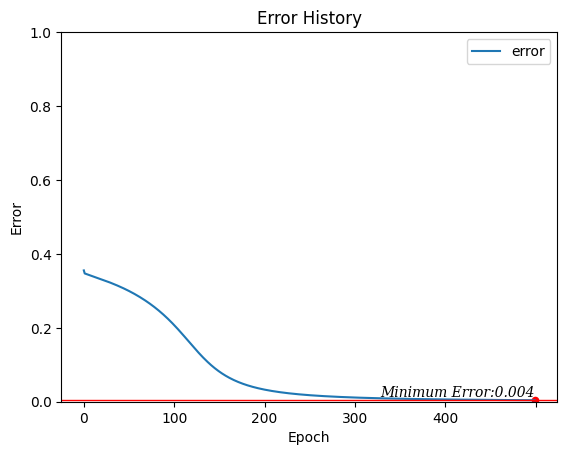

In [215]:
if __name__ == '__main__':
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 3, 1, hidden_layers=1, activation_function=sigmoid)
    # 학습 실행
    n.train(data, iterations=500, lr=0.1, mo=1.0)
    #결과 출력
    history = n.result(data)

In [202]:
n = NeuralNetwork(2, 2, 1, hidden_layers=1, activation_function=sigmoid)
print("입력층-은닉층 가중치 : ",n.weight_in)
temp_weight_in = n.weight_in
print("은닉층-출력층 가중치 : ", n.weight_out)
temp_weight_out = n.weight_out
# 학습 실행
n.train(data, iterations=500, lr=0.1, mo=1.0)
print("-"*50)
print("[학습 이후 가중치]")
print("입력층-은닉층 가중치 : ",n.weight_in)
print("은닉층-출력층 가중치 : ", n.weight_out)

입력층-은닉층 가중치 :  [[0.5453214349707934, 0.5332354472141753], [0.13112085516837124, 0.9583636524986823], [0.5978457468036138, 0.3270456201235611]]
은닉층-출력층 가중치 :  [[0.4219884172783399], [0.05924752802258271]]
--------------------------------------------------
[학습 이후 가중치]
입력층-은닉층 가중치 :  [[1.181166887947437, 4.836718150267205], [0.7938429100761524, 4.73117112904493], [1.5561503711808176, -2.7770119944832414]]
은닉층-출력층 가중치 :  [[-2.773772350727876], [6.004189185086262]]
--------------------------------------------------


TypeError: unsupported operand type(s) for -: 'list' and 'list'

--------------------------------------------------
Input: [0, 0], Predict: [0.018928660692143377]
Input: [0, 1], Predict: [0.9922546109605357]
Input: [1, 0], Predict: [0.9877991854298738]
Input: [1, 1], Predict: [0.9981889091847709]
Minimum error: 0.00029
Optimal epoch: 4999


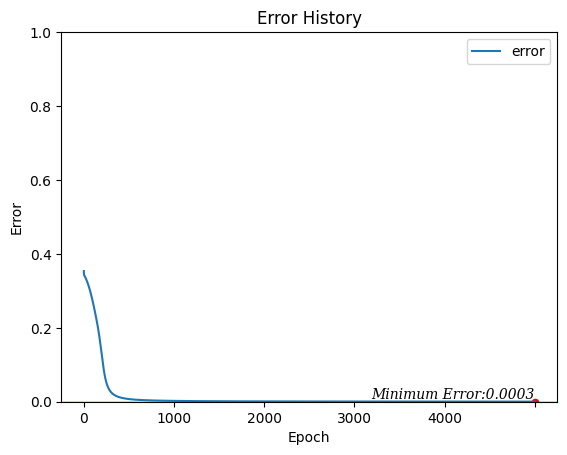

In [187]:
if __name__ == '__main__':
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 3, 1, activation_function=sigmoid)
    # 학습 실행
    n.train(data, iterations=5000, lr=0.1, mo=1.0)
    #결과 출력
    history = n.result(data)

--------------------------------------------------
Input: [0, 0], Predict: [0.0004134933988640952]
Input: [0, 1], Predict: [0.9909825085188277]
Input: [1, 0], Predict: [0.9909782361863195]
Input: [1, 1], Predict: [0.0014439555169178345]
Minimum error: 0.00008
Optimal epoch: 4999


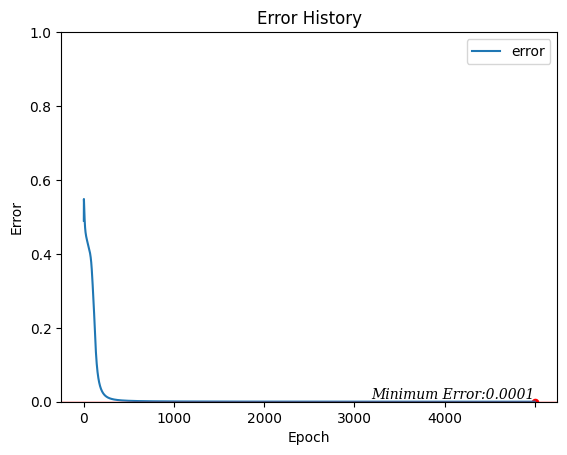

In [153]:
if __name__ == '__main__':
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 3, 1, activation_function=tanh)
    # 학습 실행
    n.train(data, iterations=5000, lr=0.1, mo=0.4)
    #결과 출력
    history = n.result(data)

--------------------------------------------------
Input: [0, 0], Predict: [0.5279598033758901]
Input: [0, 1], Predict: [0.5379602878145069]
Input: [1, 0], Predict: [0.5430696628822772]
Input: [1, 1], Predict: [0.547682101189494]
Minimum error: 0.52349
Optimal epoch: 99


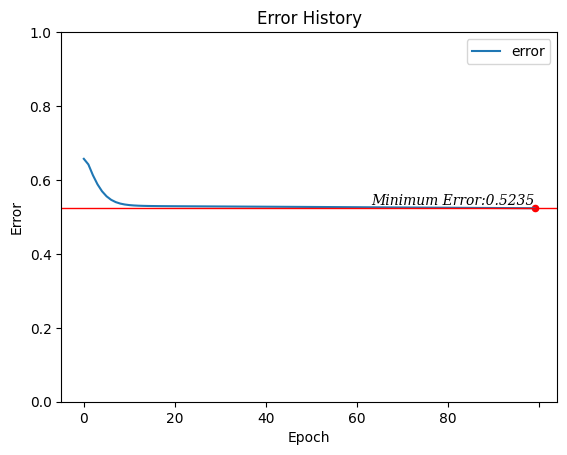

In [51]:
if __name__ == '__main__':
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 2, 1, activation_function=sigmoid)
    # 학습 실행
    n.train(data, iterations=100, lr=0.1, mo=0.9)
    #결과 출력
    n.result(data)

--------------------------------------------------
Input: [0, 0], Predict: [0.07098658131785954]
Input: [0, 1], Predict: [0.9524915067835075]
Input: [1, 0], Predict: [0.954533404022766]
Input: [1, 1], Predict: [0.06876934914689366]
Minimum error: 0.00725
Optimal epoch: 4999


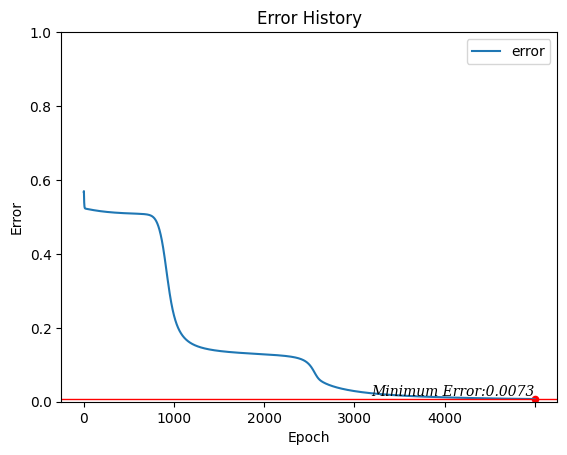

In [50]:
if __name__ == '__main__':
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, 2, 1, activation_function=sigmoid)


    # 학습 실행
    n.train(data, iterations=5000, lr=0.1, mo=0.9)
    #결과 출력
    n.result(data)

--------------------------------------------------
Input: [0, 0], Predict: [0.01175675338217724]
Input: [0, 1], Predict: [0.9846277420658917]
Input: [1, 0], Predict: [0.9849558308566557]
Input: [1, 1], Predict: [0.017287429865141802]
Minimum error: 0.00045
Optimal epoch: 4999


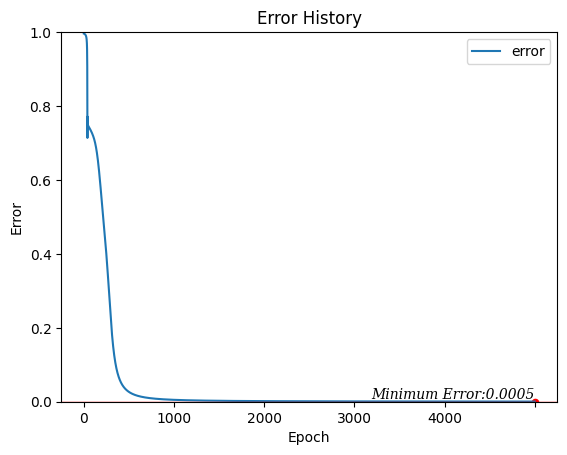

,epoch,error
0,0,0.996087
0,1,0.995999
0,2,0.995889
0,3,0.995773
0,4,0.995649
...,...,...
0,4995,0.000451
0,4996,0.000451
0,4997,0.000451
0,4998,0.000451


In [179]:
n = NeuralNetwork(2, 20, 1)
n.train(data, iterations=5000, lr=0.1, mo=0.9)
n.result(data)

은닉층 개수 : 1
학습률 : 0.1
minimum error = 0.3498336501415232
Optimal epoch: 1999


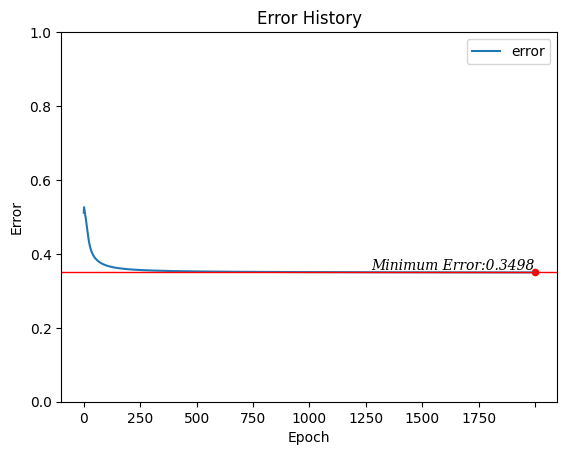

은닉층 개수 : 2
학습률 : 0.1
minimum error = 0.0003527361092097854
Optimal epoch: 1999


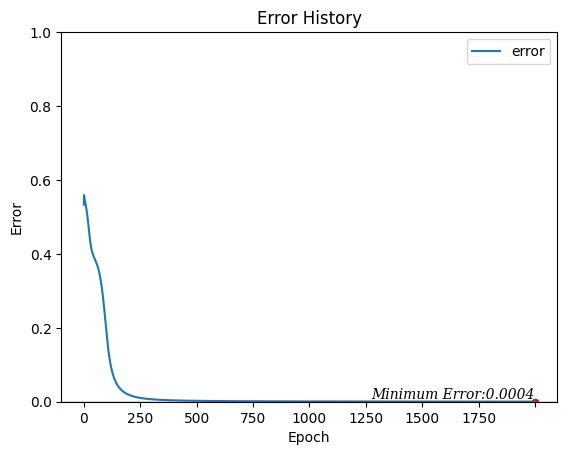

은닉층 개수 : 3
학습률 : 0.1
minimum error = 0.0002600146713190446
Optimal epoch: 1883


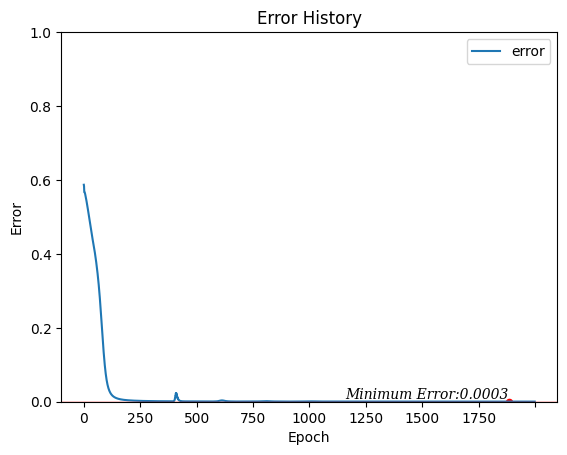

은닉층 개수 : 4
학습률 : 0.1
minimum error = 0.00045876727077432766
Optimal epoch: 1999


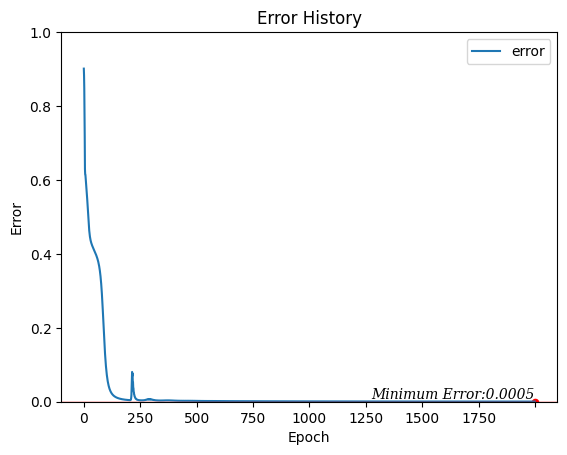

은닉층 개수 : 5
학습률 : 0.1
minimum error = 0.00129233702110466
Optimal epoch: 1998


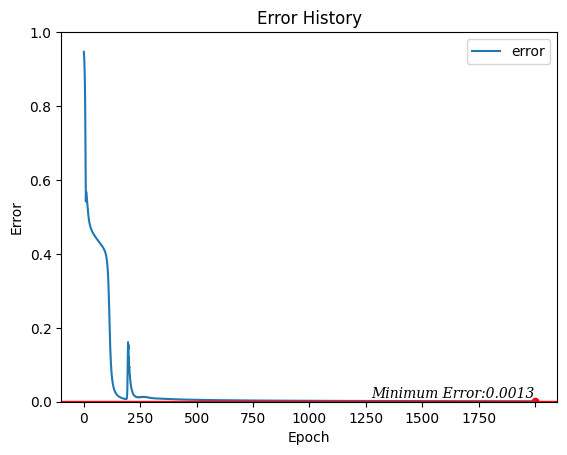

은닉층 개수 : 6
학습률 : 0.1
minimum error = 0.0008034252633564597
Optimal epoch: 1436


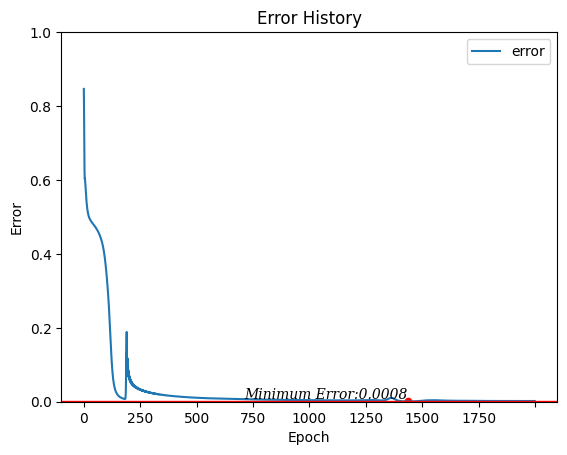

은닉층 개수 : 7
학습률 : 0.1
minimum error = 0.001162388476523815
Optimal epoch: 1540


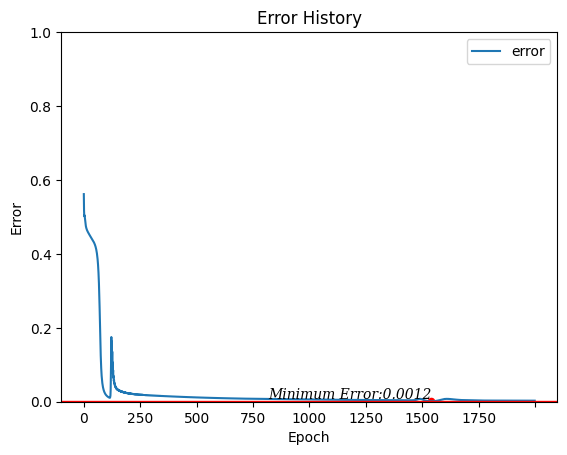

은닉층 개수 : 8
학습률 : 0.1
minimum error = 0.0004483977019921865
Optimal epoch: 1685


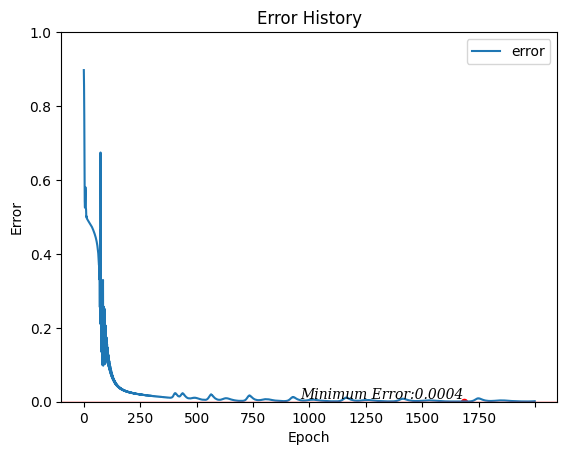

은닉층 개수 : 9
학습률 : 0.1
minimum error = 0.0009649698948504379
Optimal epoch: 1867


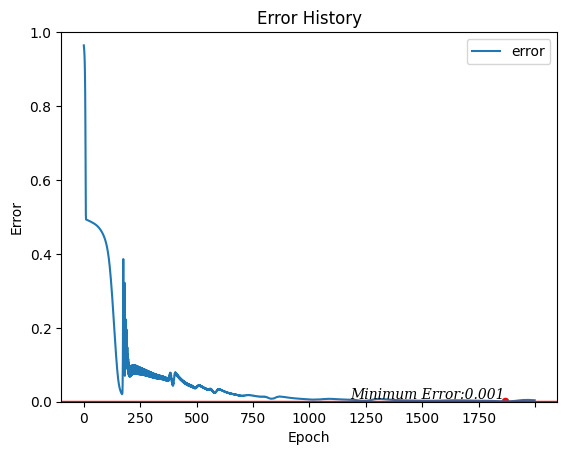

은닉층 개수 : 10
학습률 : 0.1
minimum error = 0.0015680653510243697
Optimal epoch: 1900


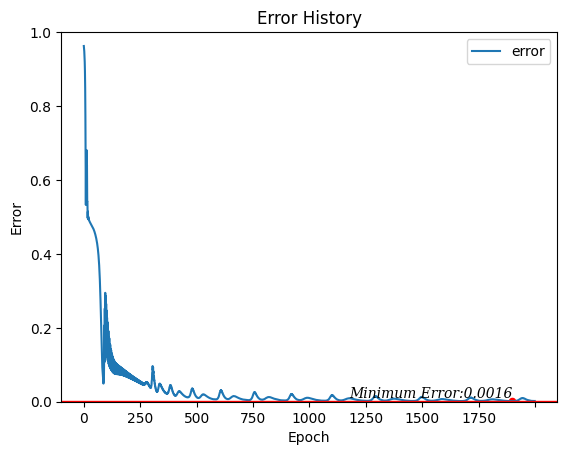

은닉층 개수 : 11
학습률 : 0.1
minimum error = 0.0021651501283567838
Optimal epoch: 1999


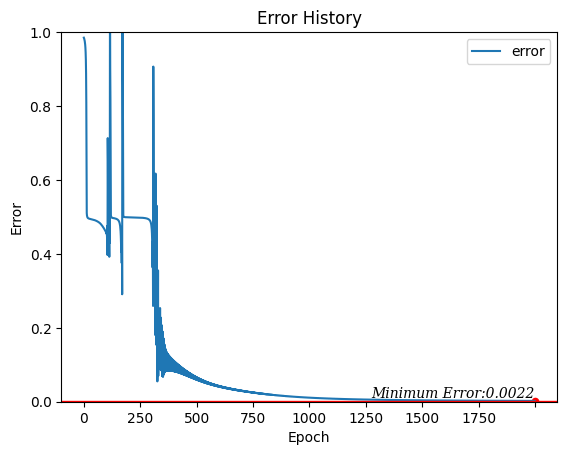

은닉층 개수 : 12
학습률 : 0.1
minimum error = 0.0014874874830679793
Optimal epoch: 1982


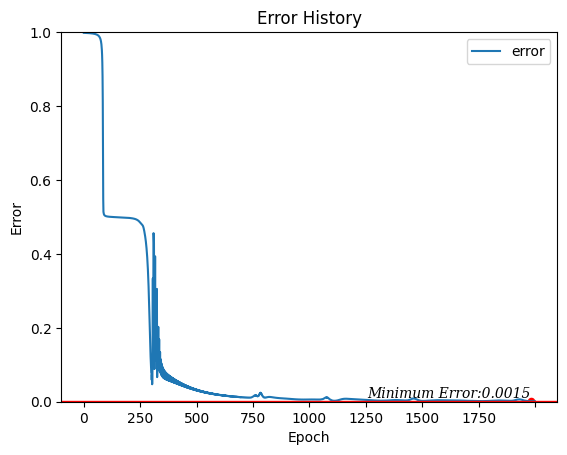

은닉층 개수 : 13
학습률 : 0.1
minimum error = 0.0018496135183295247
Optimal epoch: 1844


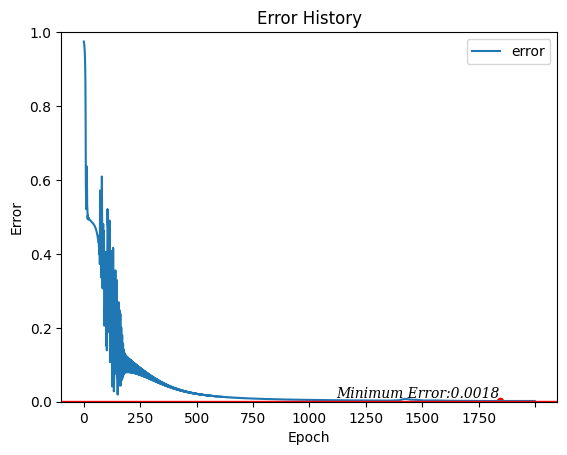

은닉층 개수 : 14
학습률 : 0.1
minimum error = 0.0019038697265986026
Optimal epoch: 1764


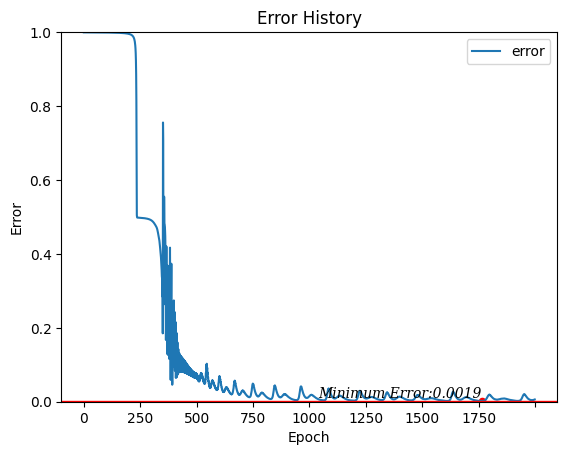

은닉층 개수 : 15
학습률 : 0.1
minimum error = 0.37066217355865394
Optimal epoch: 157


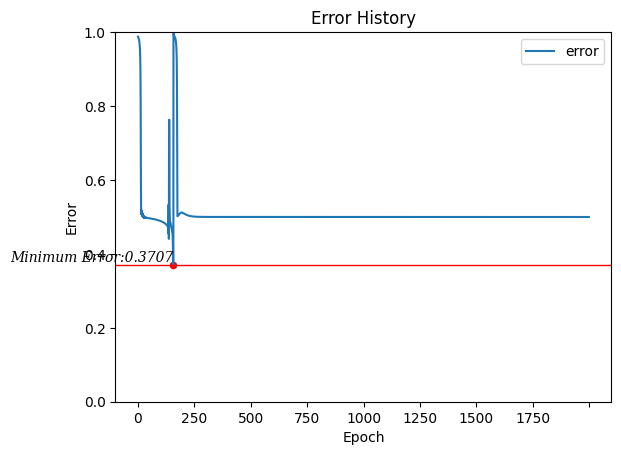

은닉층 개수 : 16
학습률 : 0.1
minimum error = 0.9958135249050488
Optimal epoch: 1999


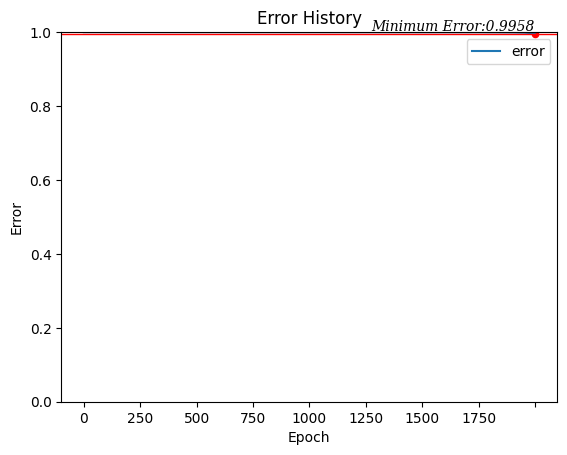

은닉층 개수 : 17
학습률 : 0.1
minimum error = 0.1851662280579553
Optimal epoch: 1579


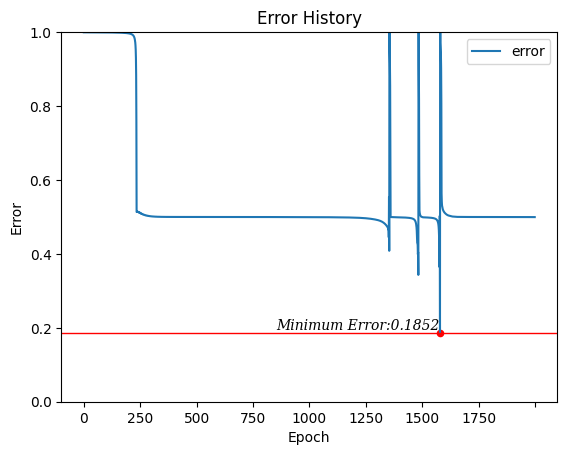

은닉층 개수 : 18
학습률 : 0.1
minimum error = 0.999939336152986
Optimal epoch: 1999


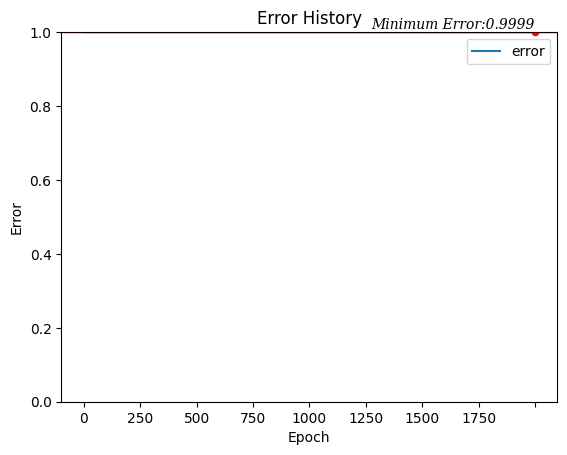

은닉층 개수 : 19
학습률 : 0.1
minimum error = 0.3850615558285166
Optimal epoch: 240


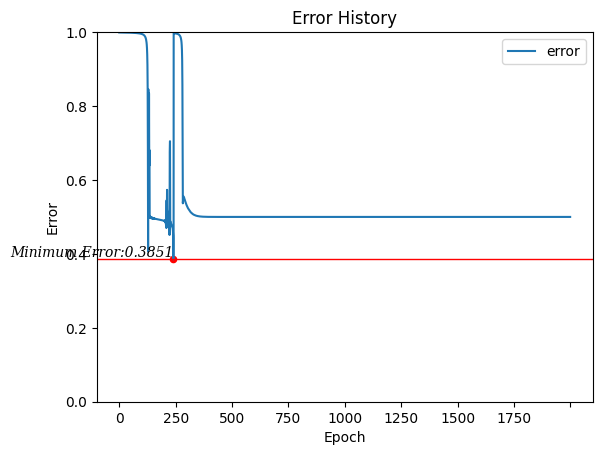

,hidden_unit_num,learning rate,error
0,1,0.1,0.349834
0,2,0.1,0.000353
0,3,0.1,0.000260
0,4,0.1,0.000459
0,5,0.1,0.001292
0,6,0.1,0.000803
0,7,0.1,0.001162
0,8,0.1,0.000448
0,9,0.1,0.000965
0,10,0.1,0.001568


In [181]:
from IPython.display import clear_output
from tqdm.auto import tqdm

#최적의 은닉층 뉴런 개수 찾기

error_df = pd.DataFrame(columns=['hidden_unit_num', 'learning rate', 'error'])
lr = 0.1

for hidden_unit_num in range(1, 20):
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork(2, hidden_unit_num, 1, activation_function=tanh)
    # 학습 실행
    n.train(data, iterations=2000, lr=0.1, mo=0.4)
    #결과 출력
    print(f"은닉층 개수 : {hidden_unit_num}")
    print(f"학습률 : {lr}")
    print(f'minimum error = {n.history["error"].min()}')
    history = n.result(data, print_result=False, show_plot=True)
    temp_df = pd.DataFrame([[hidden_unit_num, lr, history['error'].min()]], columns=['hidden_unit_num', 'learning rate', 'error'])
    error_df = pd.concat([error_df, temp_df], axis=0)

#출력창 초기화
error_df


추가로 해볼것
- 매개변수로 lr, mo 등 전달하기 -> 완료
- 최종 에러 값 출력 -> 완료
- history 반환 구현
- sigmoid, tanh, relu 등 함수명을 파라미터로 받아 적절한 함수를 사용하도록 수정 -> 완료

## 바이어스 추가

In [8]:
class NeuralNetwork_with_bias(NeuralNetwork):
    def __init__(self, num_x, num_yh, num_yo, bias=1, activation_function=sigmoid):
        super().__init__(num_x, num_yh, num_yo, bias, activation_function)
        # 바이어스 초기화
        self.bias_hidden = [1.0] * self.num_yh
        self.bias_output = [1.0] * self.num_yo
        
        def update(self, inputs):
        
        #입력층의 활성화 함수
            for i in range(self.num_x - 1):
                self.activation_input[i] = inputs[i]
            
            #은닉층의 활성화 함수
            for j in range(self.num_yh):
                sum = 0.0
                for i in range(self.num_x):
                    sum = sum + self.activation_input[i] * self.weight_in[i][j]
                #시그모이드와 tanh 중에서 활성화 함수 선택 
                self.activation_hidden[j] = self.activation_function(sum + self.bias_hidden[j], False)
            
            #출력층의 활성화 함수
            for k in range(self.num_yo):
                sum=0.0
                for j in range(self.num_yh):
                    sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
                #시그모이드와 tanh 중에서 활성화 함수 선택
                self.activation_out[k] = self.activation_function(sum + self.bias_output[k], False)
            
            return self.activation_out[:]

--------------------------------------------------
Input: [0, 0], Predict: [0.018483080216547747]
Input: [0, 1], Predict: [0.9762768885510654]
Input: [1, 0], Predict: [0.9893135982280449]
Input: [1, 1], Predict: [0.019905475800106258]
Minimum error: 0.00071
Optimal epoch: 4999


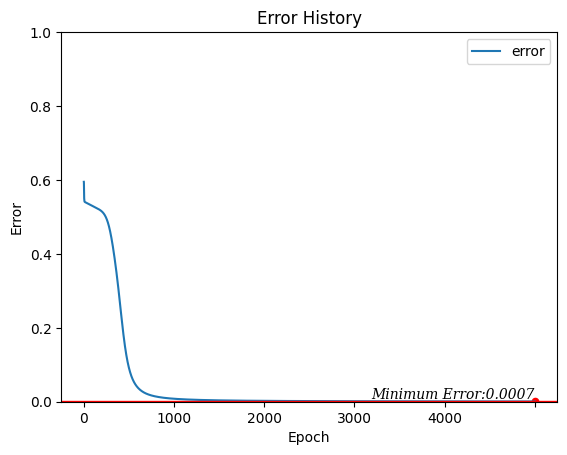

In [9]:
if __name__ == '__main__':
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork_with_bias(2, 3, 1, activation_function=sigmoid)
    # 학습 실행
    n.train(data, iterations=5000, lr=0.1, mo=0.9)
    #결과 출력
    history_bias = n.result(data)

In [147]:
from IPython.display import clear_output
from tqdm.auto import tqdm

#최적의 은닉층 뉴런 개수 찾기

error_df = pd.DataFrame(columns=['hidden_unit_num','optimal_epoch', 'learning rate', 'error'])
hidden_unit_num = 2

for lr in tqdm(range(100, 0, -1), leave=False):
    lr = lr / 100000
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork_with_bias(2, hidden_unit_num, 1, activation_function=tanh)
    # 학습 실행
    n.train(data, iterations=5000, lr=lr, mo=0.4)
    #결과 출력
    print(f"은닉층 개수 : {hidden_unit_num}")
    print(f"학습률 : {lr}")
    print(f'minimum error = {n.history["error"].min()}')
    history = n.result(data, print_result=False, show_plot=False)
    min_error = history['error'].min()
    optimal_epoch = history[history['error'] == min_error]['epoch'].values[0]
    temp_df = pd.DataFrame([[hidden_unit_num,optimal_epoch, lr, history['error'].min()]], columns=['hidden_unit_num','optimal_epoch', 'learning rate', 'error'])
    error_df = pd.concat([error_df, temp_df], axis=0)

#출력창 초기화
clear_output(wait=True)
error_df


,hidden_unit_num,optimal_epoch,learning rate,error
0,2,4963,0.00100,0.000091
0,2,4999,0.00099,0.000096
0,2,4999,0.00098,0.000091
0,2,4999,0.00097,0.000089
0,2,4999,0.00096,0.000091
...,...,...,...,...
0,2,4999,0.00005,0.000089
0,2,4999,0.00004,0.000090
0,2,4999,0.00003,0.000090
0,2,4999,0.00002,0.000089


In [148]:
#error 값이 최소인 행 찾기
error_df[error_df['error'] == error_df['error'].min()]

,hidden_unit_num,optimal_epoch,learning rate,error
0,2,4999,0.00056,0.000089


In [138]:
from IPython.display import clear_output
from tqdm.auto import tqdm

#최적의 은닉층 뉴런 개수 찾기

error_df = pd.DataFrame(columns=['hidden_unit_num', 'learning rate', 'error'])
hidden_unit_num = 2
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

for lr in learning_rates:
    # 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
    n = NeuralNetwork_with_bias(2, hidden_unit_num, 1, activation_function=tanh)
    # 학습 실행
    n.train(data, iterations=5000, lr=lr, mo=0.4)
    #결과 출력
    print(f"은닉층 개수 : {hidden_unit_num}")
    print(f"학습률 : {lr}")
    print(f'minimum error = {n.history["error"].min()}')
    history = n.result(data, print_result=False, show_plot=False)
    temp_df = pd.DataFrame([[hidden_unit_num, lr, history['error'].min()]], columns=['hidden_unit_num', 'learning rate', 'error'])
    error_df = pd.concat([error_df, temp_df], axis=0)

#출력창 초기화
clear_output(wait=True)
error_df


,hidden_unit_num,learning rate,error
0,2,0.100000,0.000123
0,2,0.010000,0.000092
0,2,0.001000,0.000090
0,2,0.000100,0.000089
0,2,0.000010,0.000091
0,2,0.000001,0.000090


In [140]:
#error 값이 최소인 행 찾기
error_df[error_df['error'] == error_df['error'].min()]

,hidden_unit_num,learning rate,error
0,2,0.0001,0.000089


## 은닉층 선형 층으로 만들기

In [226]:
class NeuralNetwork_linear:
    def __init__(self, num_x, num_yh, num_yo, hidden_layers = 1,bias=1, activation_function=sigmoid):
        
        #입력 값 개수(num_x), 은닉층 개수(num_yh), 출력층 개수(num_yo), 바이어스
        self.num_x = num_x + bias
        self.num_yh = num_yh
        self.num_yo = num_yo
        self.hidden_layers = hidden_layers
        self.error = 0 #최종 오차율(에러율) 담기 위한 객체 속성
        self.activation_function = activation_function
        
        #활성화 함수 초깃값
        self.activation_input = [1.0] * self.num_x
        self.activation_hidden = [1.0] * self.num_yh
        self.activation_out = [1.0] * self.num_yo
        
        #가중치 입력 초깃값
        self.weight_in = makeMatrix(self.num_x, self.num_yh)
        for i in range(self.num_x):
            for j in range(self.num_yh):
                self.weight_in[i][j] = random.random()
        
        #가중치 출력 초깃값
        self.weight_out = makeMatrix(self.num_yh, self.num_yo)
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                self.weight_out[j][k] = random.random()
                
        #모멘텀 SGD를 위한 이전 가중치 초깃값
        self.gradient_in = makeMatrix(self.num_x, self.num_yh)
        self.gradient_out = makeMatrix(self.num_yh, self.num_yo)
        
        #히스토리 저장을 위한 데이터 프레임
        self.history = pd.DataFrame(columns=['epoch','error'])
        
            #업데이트 함수
    def update(self, inputs):
        # 입력층의 활성화 함수
        for i in range(self.num_x - 1):
            self.activation_input[i] = inputs[i]

        # 은닉층의 활성화 함수
        for j in range(self.num_yh):
            sum = 0.0
            for i in range(self.num_x):
                sum = sum + self.activation_input[i] * self.weight_in[i][j]
            self.activation_hidden[j] = linear(sum, False)  # Change here to linear function

        # 출력층의 활성화 함수
        for k in range(self.num_yo):
            sum=0.0
            for j in range(self.num_yh):
                sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
            self.activation_out[k] = tanh(sum, False)
        
        return self.activation_out[:]
    
    #역전파 실행
    def backPropagate(self, targets, lr, mo):
    
        #델타 출력 계산
        output_deltas = [0.0] * self.num_yo
        for k in range(self.num_yo):
            error = targets[k] - self.activation_out[k]
            #시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            output_deltas[k] = self.activation_function(self.activation_out[k], True) * error
            
        #은닉 노드의 오차 함수
        hidden_deltas = [0.0] * self.num_yh
        for j in range(self.num_yh):
            error=0.0
            for k in range(self.num_yo):
                error = error + output_deltas[k] * self.weight_out[j][k]
            #시그모이드와 tanh 중에서 활성화 함수 선택, 미분 적용
            hidden_deltas[j] = self.activation_function(self.activation_hidden[j], True) * error

    
        #출력 가중치 업데이트
        for j in range(self.num_yh):
            for k in range(self.num_yo):
                gradient = output_deltas[k] * self.activation_hidden[j]
                v = mo * self.gradient_out[j][k] - lr * gradient
                self.weight_out[j][k] += v
                self.gradient_out[j][k] = gradient
        
        #입력 가중치 업데이트
        for i in range(self.num_x):
            for j in range(self.num_yh):
                gradient = hidden_deltas[j] * self.activation_input[i]
                v = mo * self.gradient_in[i][j] - lr * gradient
                self.weight_in[i][j] += v
                self.gradient_in[i][j] = gradient
                
        #오차 계산(최소 제곱법)
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5 * (targets[k] - self.activation_out[k]) ** 2
        
        return error

#학습 실행
    def train(self, patterns, iterations, lr, mo):
        for i in range(iterations):
            error=0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets, lr, mo)
                self.error = error #최종 에러값을 객체 속성값으로 저장
                
            #history 데이터 프레임에 에포크마다 오차값 추가
            error_history = pd.DataFrame([[i,error]], columns=['epoch','error'])
            self.history = pd.concat([self.history, error_history], axis=0)
                
            # if i % 500 == 0:
            #     print('error: %-.5f' % error)
                
#결과 출력
    def result(self, patterns, print_result = True, show_plot=True):
       
        min_error = self.history['error'].min()
       
        if print_result == True:
            print("-"*50) 
            for p in patterns:
                print('Input: %s, Predict: %s' % (p[0], self.update(p[0])))
            
            print("Minimum error: %-.5f" % min_error)
        
        if show_plot == True:
            #plot 제목 설정
            self.history.plot(x='epoch', y='error')
            plt.title('Error History')
            plt.xlabel('Epoch')
            plt.ylabel('Error')
            plt.ylim(0, 1)
            
            #plot에 minimum_error 위치에 선 추가
            plt.axhline(y=min_error, color='r', linewidth=1)
            #minimum_error 값을 갖는 epoch 찾기
            optimal_epoch = self.history[self.history['error'] == min_error]['epoch'].values[0]
            #minimum_error 값을 갖는 epoch 위치에 점 추가
            plt.scatter(optimal_epoch, min_error, color='r', s=20)
            #minimum_error 위치에 텍스트 추가
            plt.text(optimal_epoch, min_error, f'Minimum Error:{round(min_error, 4)}', family='serif', style='italic', ha='right', va='bottom')
            
            print(f'Optimal epoch: {optimal_epoch}')
            
            plt.show()
        
        return self.history

/var/folders/3h/f28l_h7n3rdf1ffk62lr2qrw0000gn/T/ipykernel_78407/1349139946.py:53: RuntimeWarning: overflow encountered in double_scalars
  sum = sum + self.activation_hidden[j] * self.weight_out[j][k]
/var/folders/3h/f28l_h7n3rdf1ffk62lr2qrw0000gn/T/ipykernel_78407/1349139946.py:53: RuntimeWarning: invalid value encountered in double_scalars
  sum = sum + self.activation_hidden[j] * self.weight_out[j][k]


--------------------------------------------------
Input: [0, 0], Predict: [nan]
Input: [0, 1], Predict: [nan]
Input: [1, 0], Predict: [nan]
Input: [1, 1], Predict: [nan]
Minimum error: 1.06867
Optimal epoch: 3


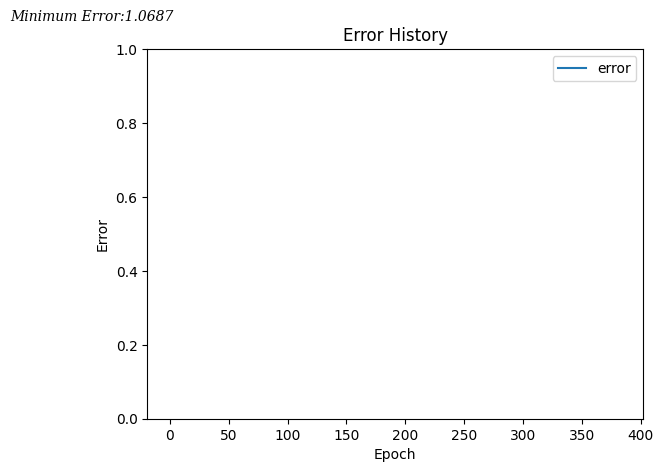

In [227]:
data = [
    [[0,0], [0]],
    [[0,1], [1]],
    [[1,0], [1]],
    [[1,1], [0]]
]

# 두 개의 입력 값, 두 개의 레이어, 하나의 출력 값을 갖도록 설정
n = NeuralNetwork_linear(2, 3, 1, activation_function=linear)
# 학습 실행

n.train(data, iterations=5000, lr=0.1, mo=0.9)
#결과 출력
history_bias = n.result(data)
